# Metrics Analysis Notebook

This notebook loads Prometheus `.prom` files and generates various plots for analyzing simulation performance:

1. **RPC Duration Distribution** - Histogram of RPC durations by method
2. **RPC Blocking Time Distribution** - Histogram of blocking times per service
3. **Queue Depth per Service** - Histogram of concurrent RPCs per service
4. **Rollout Duration Distribution** - How long each rollout takes
5. **Step Duration Distribution** - How long each simulation step takes
6. **CPU Utilization** - Box plot of CPU usage for high-utilization processes
7. **GPU Utilization & Memory** - Box plots of GPU metrics


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl

from alpasim_runtime.telemetry.plot_metrics import (
    METHODS_TO_PLOT,
    generate_metrics_plot,
    _extract_histograms,
    _extract_gauges,
    _build_histograms_dataframe,
    _build_gauges_dataframe,
    _compute_summary_stats,
)

# Configure display
pl.Config.set_tbl_rows(100)
%matplotlib inline


/home/migl/workspace/alpasim2/src/runtime/alpasim_runtime/telemetry/resources.py:29: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


In [2]:
# Load metrics data
# Update this path to point to your metrics file
METRICS_PATH = Path("~/workspace/alpasim2/.wizard/metrics/metrics.prom").expanduser()

# Alternative: use absolute path
# METRICS_PATH = Path("/path/to/your/metrics.prom")

print(f"Loading metrics from: {METRICS_PATH.resolve()}")

histograms = _extract_histograms(METRICS_PATH)
gauges = _extract_gauges(METRICS_PATH)

print(f"Loaded {len(histograms)} histograms and {len(gauges)} gauges")

# Show available metric types
histogram_types = sorted(set(h.name for h in histograms))
gauge_types = sorted(set(g.name for g in gauges))

print(f"\nHistogram types: {histogram_types}")
print(f"Gauge types: {gauge_types}")

Loading metrics from: /home/migl/workspace/alpasim2/.wizard/metrics/metrics.prom
Loaded 128 histograms and 274 gauges

Histogram types: ['rollout_duration_seconds', 'rpc_blocking_seconds', 'rpc_duration_seconds', 'rpc_queue_depth_at_start', 'step_duration_seconds']
Gauge types: ['event_loop_idle_seconds_total', 'event_loop_poll_seconds_total', 'event_loop_work_seconds_total', 'gpu_memory_total_bytes', 'gpu_memory_used_bytes', 'gpu_utilization', 'process_cpu_utilization', 'rollout_duration_seconds_created', 'rpc_blocking_seconds_created', 'rpc_duration_seconds_created', 'rpc_queue_depth_at_start_created', 'simulation_rollout_count', 'simulation_seconds_per_rollout', 'simulation_total_seconds', 'step_duration_seconds_created']


In [3]:
# Build DataFrames
histograms_df = _build_histograms_dataframe(histograms)
gauges_df = _build_gauges_dataframe(gauges)

print(f"Histograms DataFrame shape: {histograms_df.shape}")
print(f"Gauges DataFrame shape: {gauges_df.shape}")

Histograms DataFrame shape: (2364, 9)
Gauges DataFrame shape: (146, 8)


In [4]:
# Compute summary stats
idle_percentage, sim_seconds_per_rollout = _compute_summary_stats(gauges_df)

print(f"Async worker idle percentage: {idle_percentage:.2%}")
print(f"Sim seconds per rollout: {sim_seconds_per_rollout:.2f}")

Async worker idle percentage: 83.66%
Sim seconds per rollout: 2.84


14:12:10.106 INFO:	Loading metrics from: /home/migl/workspace/alpasim2/.wizard/metrics/metrics.prom


14:12:10.207 INFO:	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
14:12:10.210 INFO:	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
14:12:10.249 INFO:	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
14:12:10.251 INFO:	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
14:12:10.359 INFO:	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast t

Plot saved to: /tmp/vis.png


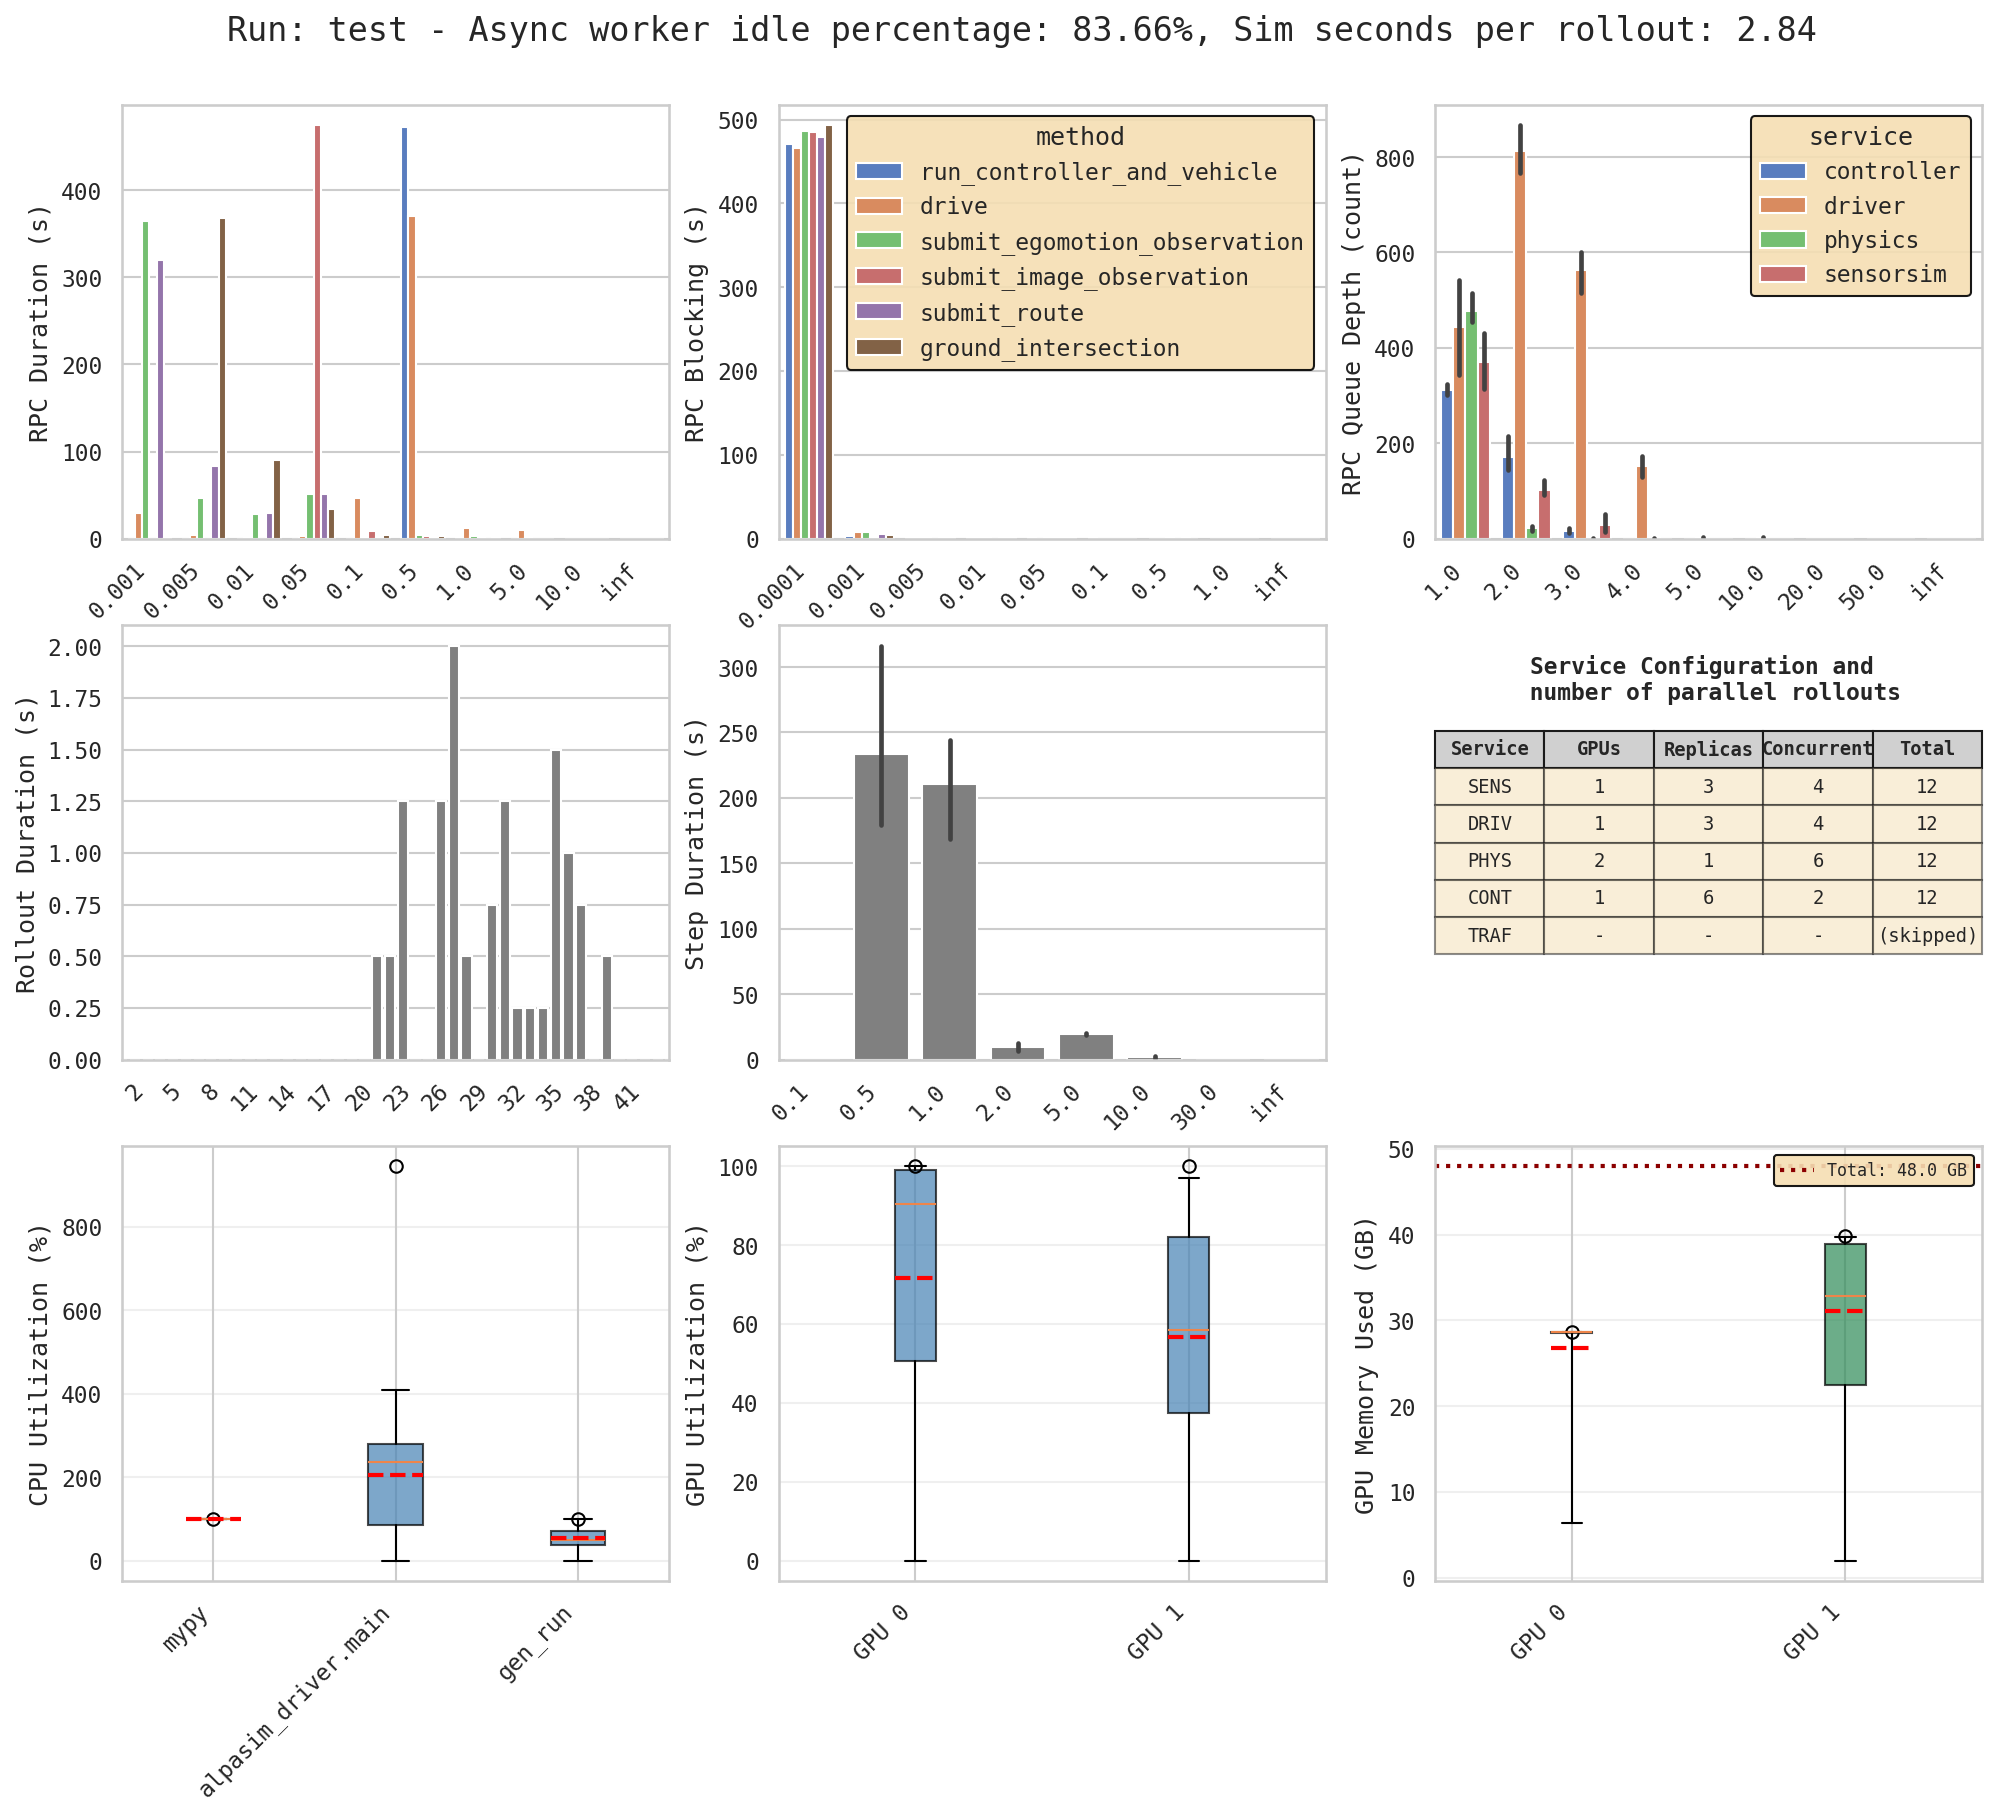

In [5]:
# Generate the full metrics plot using the module function
# This saves the plot to a file and returns the path
output_path = generate_metrics_plot(METRICS_PATH, "/tmp/vis.png", "test")


print(f"Plot saved to: {output_path}")

# Display the saved image
from IPython.display import Image, display

display(Image(filename=str(output_path)))

## Explore Data Interactively

The cells below allow you to explore the raw data in more detail.


In [ ]:
# Explore histogram data
histograms_df

In [ ]:
# Explore gauge data
gauges_df

In [ ]:
# Filter to specific metrics
all_methods = [m for methods in METHODS_TO_PLOT.values() for m in methods]

# RPC Duration for specific methods
rpc_duration = histograms_df.filter(
    pl.col("metric") == "rpc_duration_seconds",
    pl.col("method").is_in(all_methods) if "method" in histograms_df.columns else True,
)
rpc_duration

In [ ]:
# CPU utilization stats
cpu_stats = gauges_df.filter(pl.col("metric") == "process_cpu_utilization")
cpu_stats

In [ ]:
# GPU stats
gpu_stats = gauges_df.filter(
    pl.col("metric").is_in(
        ["gpu_memory_used_bytes", "gpu_utilization", "gpu_memory_total_bytes"]
    )
)
gpu_stats